# Шаг 6: Final_model
>  Формирование модели, которая на вход получает исходные признаки (без обработки), а на выходе выдает предсказания.

In [1]:
folder = 'final_model'

## Импорт библиотек, константы и загрузка данных

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option("display.max_columns", 50)
pd.options.display.max_rows = 20

import numpy as np

import seaborn as sns
sns.set_style("darkgrid")  
sns.set_context("talk", font_scale=0.6)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(
    {"lines.linewidth": 1, "patch.facecolor": "#ebe3df", "axes.facecolor": "#ebe3df"})

from tqdm import tqdm
from tqdm import tqdm_notebook


import association_metrics as am

In [3]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [4]:
# Базовые модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Выбор параметров
from sklearn.model_selection import cross_val_score, StratifiedKFold

import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

from sklearn.metrics import roc_auc_score
from mlxtend.evaluate import bias_variance_decomp

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.decomposition import PCA

In [7]:
RANDOM_STATE = 42

## Final_model

#### Сформируем Pipeline для наилучшей модели и проверим ее работоспособность на исходных (необработанных) данных.

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin


class initial_prep(BaseEstimator, TransformerMixin):
    """
    Параметры:

    """

    def __init__(self, copy=True):

        # все параметры для инициализации публичных атрибутов
        # должны быть заданы в методе __init__
        # публичные атрибуты
        self.copy = copy
    
    

    def __scale_control (self, df: pd.Series, min_val: float=None, max_val: float=None, nan_val: float=None):
        '''Функция определения области допустимых значений числового признака'''

        df_local = df.copy()
        assert (min_val != None) and (type(min_val) != str), 'Неверное значение min_val'
        assert (max_val != None) and (type(max_val) != str), 'Неверное значение max_val'

        df_local = pd.Series(np.where(df_local < min_val, np.nan, df_local))
        df_local = pd.Series(np.where(df_local > max_val, np.nan, df_local))

        if nan_val != None:
            df_local = pd.Series(np.where(df_local.isnull(), nan_val, df_local))

        return df_local.values
   

    def __label_control(self, df: pd.Series, ligal_cat_list: list=None, other_cat = None) -> pd.Series:
        '''Функция определения области допустимых значений категориального признака'''
        df_local = df.copy()

        if other_cat is None:
            other_cat = 'Other'

        df_local = df_local.apply(lambda x: x if x in ligal_cat_list else other_cat)

        return df_local
    

    def __TotalCharges_transform_fnc(self, x):
        '''Функция преобразования str -> float'''
        try: 
            out = pd.to_numeric(x)
        except: 
            out = np.nan
        return out
    

    def __BaseLine_FE(self, df: pd.DataFrame) -> pd.DataFrame:

        '''
            Функция базовой трансформации признаков:
                1) Отбор нужных признаков (контроль наличия);
                2) Преобразование к нужному типу данных;
                3) Контроль допустимых значений (шкал)
        '''

        # Проверка наличия в DataFrame необходимых признаков
        ## исключаем 'customerID'
        neccesary_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
                             'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                             'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                             'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
                             'MonthlyCharges', 'TotalCharges']

        df_cond = 'error' not in ['error' for col in neccesary_columns if col not in list(df.columns)]
        assert df_cond, 'Отсутствуют необходимые признаки'
        
        # Отбор датасета
        df_local = df[neccesary_columns].copy()


        # ______________Числовые признаки________________

        # Обработка TotalCharges
        df_local['TotalCharges'] = df_local['TotalCharges'].apply(self.__TotalCharges_transform_fnc)
        df_local['TotalCharges'] = self.__scale_control(df_local['TotalCharges'], min_val=0, max_val=1000000, nan_val=0.0)

        # Обработка MonthlyCharges
        df_local['MonthlyCharges'] = self.__scale_control(df_local['MonthlyCharges'], min_val=0, max_val=1000000, nan_val=0.0)

        # Обработка tenure
        df_local['tenure'] = self.__scale_control(df_local['tenure'], min_val=0, max_val=800, nan_val=0)

        #_____________Категориальные признаки_____________
        # SeniorCitizen

        # Преобразование int -> object
        df_local['SeniorCitizen'] = self.__label_control(df_local['SeniorCitizen'], ligal_cat_list=[0, 1], other_cat=1)
        df_local['SeniorCitizen'] = df_local['SeniorCitizen'].map({0: 'No', 1:'Yes'})


        df_local['PhoneService'] = self.__label_control(df_local['PhoneService'], ligal_cat_list=['No', 'Yes'], other_cat='Yes')
        df_local['MultipleLines'] = self.__label_control(df_local['MultipleLines'], ligal_cat_list=['No', 'No phone service', 'Yes'], other_cat='No')
        df_local['Dependents'] = self.__label_control(df_local['Dependents'], ligal_cat_list=['No', 'Yes'], other_cat='No')
        df_local['Contract'] = self.__label_control(df_local['Contract'], ligal_cat_list=['Month-to-month', 'One year', 'Two year'], other_cat='Month-to-month')
        df_local['TechSupport'] = self.__label_control(df_local['TechSupport'], ligal_cat_list=['No', 'No internet service', 'Yes'], other_cat='No')
        df_local['StreamingMovies'] = self.__label_control(df_local['StreamingMovies'], ligal_cat_list=['No', 'No internet service', 'Yes'], other_cat='No')
        df_local['StreamingTV'] = self.__label_control(df_local['StreamingTV'], ligal_cat_list=['No', 'No internet service', 'Yes'], other_cat='No')
        df_local['OnlineBackup'] = self.__label_control(df_local['OnlineBackup'], ligal_cat_list=['No', 'No internet service', 'Yes'], other_cat='No')
        df_local['DeviceProtection'] = self.__label_control(df_local['DeviceProtection'], ligal_cat_list=['No', 'No internet service', 'Yes'], other_cat='No')
        df_local['OnlineSecurity'] = self.__label_control(df_local['OnlineSecurity'], ligal_cat_list=['No', 'No internet service', 'Yes'], other_cat='No')
        df_local['InternetService'] = self.__label_control(df_local['InternetService'], ligal_cat_list=['DSL', 'Fiber optic', 'No'], other_cat='No')
        df_local['PaperlessBilling'] = self.__label_control(df_local['PaperlessBilling'], ligal_cat_list=['No', 'Yes'], other_cat='Yes')
        df_local['PaymentMethod'] = self.__label_control(df_local['PaymentMethod'], ligal_cat_list=['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check'], other_cat='Bank transfer (automatic)')
        df_local['Partner'] = self.__label_control(df_local['Partner'], ligal_cat_list=['No', 'Yes'], other_cat='No')
        df_local['gender'] = self.__label_control(df_local['gender'], ligal_cat_list=['Female', 'Male'], other_cat='Male')

        return df_local
    

    def fit(self, X, y=None):
        # ничего не делаем )) 
        return self

    def transform(self, X):

        if self.copy:
            X = X.copy()
            
        X = self.__BaseLine_FE(X)
        
        # transform возвращает X
        return X

In [20]:
class Feature_transf(BaseEstimator, TransformerMixin):
    """
    Класс преобразования признаков

    """

    def __init__(self, copy=True):

        self.copy = copy    
     
    def __TotalCharges_log(self, df: pd.Series) -> pd.DataFrame:
    
        '''
            Функция дополнительной трансформации признаков:
                1) Преобразование признака TotalCharges на log шкалу;
        '''

        p = 0.25537409875188244
        df_local = df.copy()

        # Обработка TotalCharges
        df_local = np.where(df_local.apply(lambda x: True if (x==0 or x==np.nan) else False), 0, 
                            df_local.apply(lambda x: ((x**p) - 1)/p))

        return df_local
    

    def fit(self, X, y=None):
        # ничего не делаем )) 
        return self

    def transform(self, X):

        if self.copy:
            X = X.copy()  
           
        X['TotalCharges']= self.__TotalCharges_log(X['TotalCharges'])
        
        # transform возвращает X
        return X

In [21]:
def get_LogReg_pipe():
    
    '''
    Pipeline модели LogisticRegression
    '''
    
    categoric_cols = ['gender',
     'SeniorCitizen',
     'Partner',
     'Dependents',
     'PhoneService',
     'MultipleLines',
     'InternetService',
     'OnlineSecurity',
     'OnlineBackup',
     'DeviceProtection',
     'TechSupport',
     'StreamingTV',
     'StreamingMovies',
     'Contract',
     'PaperlessBilling',
     'PaymentMethod']

    numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']


    # Трансформер числовых признаков
    numeric_pipe = Pipeline([
            ('imputer', SimpleImputer()),
            ('scaler', StandardScaler())])

    # Трансформер категориальных признаков
    categoric_pipe = Pipeline([
            ('OHE', OneHotEncoder(sparse=False))])

    transformers = [("numeric", numeric_pipe, numeric_cols), 
                    ("categoric", categoric_pipe, categoric_cols)]

    Preprocessor = Pipeline([
                    ('Initial_prep', initial_prep()),
                    ('Feature_transf', Feature_transf()),
                    ('ColumnTransformer', ColumnTransformer(transformers=transformers)),
                    ('PCA', PCA(n_components=21)),])

    log_reg_pipe = Pipeline([
            
            ('Preprocessor', Preprocessor),
            ('Model', LogisticRegression())])
    
    return log_reg_pipe

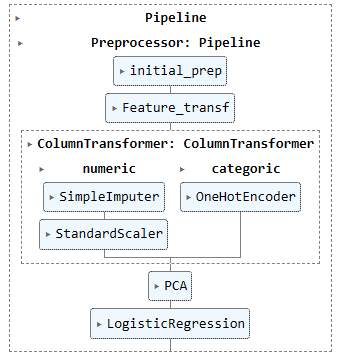

In [26]:
best_model = get_LogReg_pipe()

#### Применим к модели найденные на предыдущем этапе наилучшие параметры

In [29]:
best_params = pd.read_pickle('../results/2. improvement_1/optuna_model_results.pkl')
best_model.set_params(**best_params['LogisticRegression'])

Pipeline(steps=[('Preprocessor',
                 Pipeline(steps=[('Initial_prep', initial_prep()),
                                 ('Feature_transf', Feature_transf()),
                                 ('ColumnTransformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['tenure',
                                                                    'MonthlyCharges',
                                                                    'TotalCharges']),
                                                                  ('categoric',
                                                                   Pipeline(steps=[('OHE',
                                                                                    OneHotEncoder(sp...
                                                                    'SeniorCitizen',
                                                                    'Partner',
                                                                    'Dependents',
                                                                    'PhoneService',
                                                                    'MultipleLines',
                                                                    'InternetService',
                                                                    'OnlineSecurity',
                                                                    'OnlineBackup',
                                                                    'DeviceProtection',
                                                                    'TechSupport',
                                                                    'StreamingTV',
                                                                    'StreamingMovies',
                                                                    'Contract',
                                                                    'PaperlessBilling',
                                                                    'PaymentMethod'])])),
                                 ('PCA', PCA(n_components=21))])),
                ('Model',
                 LogisticRegression(C=0.015, class_weight='balanced',
                                    solver='liblinear'))])

## Проверка работоспособности

Загрузим исходные (необработанные) данные

In [30]:
df = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col=None)
display(df.head())
display(df.tail())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


Разделим на X и y

In [32]:
X = df.drop('Churn', axis=1)
y = df['Churn']

Разделим на обучающую выборку и тестовую

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки:  {X_test.shape}")

Размер обучающей выборки: (4930, 20)
Размер тестовой выборки:  (2113, 20)


Посмотрим на X

In [36]:
X.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


Все признаки в исходном состоянии

In [38]:
params = {
    'description': 'Final_model',
    'model': best_model,
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test
}

model_scores = test_Model(**params)
model_scores



***Final_model***
Step 1: Обучение
Step 2: Предсказание на train
Step 3: Предсказание на test
***Done***


,train_score,test_score
Final_model,0.848115,0.844756


## Сохранение модели

In [39]:
best_model.fit(X, y)

Pipeline(steps=[('Preprocessor',
                 Pipeline(steps=[('Initial_prep', initial_prep()),
                                 ('Feature_transf', Feature_transf()),
                                 ('ColumnTransformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['tenure',
                                                                    'MonthlyCharges',
                                                                    'TotalCharges']),
                                                                  ('categoric',
                                                                   Pipeline(steps=[('OHE',
                                                                                    OneHotEncoder(sp...
                                                                    'SeniorCitizen',
                                                                    'Partner',
                                                                    'Dependents',
                                                                    'PhoneService',
                                                                    'MultipleLines',
                                                                    'InternetService',
                                                                    'OnlineSecurity',
                                                                    'OnlineBackup',
                                                                    'DeviceProtection',
                                                                    'TechSupport',
                                                                    'StreamingTV',
                                                                    'StreamingMovies',
                                                                    'Contract',
                                                                    'PaperlessBilling',
                                                                    'PaymentMethod'])])),
                                 ('PCA', PCA(n_components=21))])),
                ('Model',
                 LogisticRegression(C=0.015, class_weight='balanced',
                                    solver='liblinear'))])

In [40]:
import pickle

with open('../models/final_model.pickle', 'wb') as f:
    pickle.dump(best_model, f)